In [11]:
#get started by loading the relevant libraries, not sure all of them are needed, I collected them throughout my trials
import pandas as pd
import matplotlib.pyplot as plt
import pathlib2 as pathlib
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [12]:
#setting the path
cwd=pathlib.Path.cwd()
datadirpath=cwd.joinpath("data")
rawdatapath=datadirpath.joinpath("raw")

In [13]:
user_ratings_df=pd.read_csv(rawdatapath.joinpath("collaborative_books_df.csv"))
user_ratings_df=user_ratings_df.drop([user_ratings_df.columns[0]],axis=1) # removed unnamed index column
print(user_ratings_df.columns)
print(user_ratings_df.head)

Index(['title', 'book_id', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating'],
      dtype='object')
<bound method NDFrame.head of                      title  book_id  user_id_mapping  book_id_mapping  \
0       I Am the Messenger    19057             1537              299   
1       I Am the Messenger    19057            23039              299   
2       I Am the Messenger    19057            39096              299   
3       I Am the Messenger    19057            14631              299   
4       I Am the Messenger    19057            32816              299   
...                    ...      ...              ...              ...   
196291            Coraline    17061            58417              106   
196292            Coraline    17061             9941              106   
196293            Coraline    17061            31383              106   
196294            Coraline    17061            33833              106   
196295            Coraline    17061

In [14]:
# Count unique entries in 'column_name'
unique_count = user_ratings_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count}")

Number of unique entries: 66909


In [15]:
book_metadata_df=pd.read_csv(rawdatapath.joinpath("collaborative_book_metadata.csv"))
book_metadata_df=book_metadata_df.drop([book_metadata_df.columns[0]],axis=1) # removed unnamed index column
print(book_metadata_df.columns)
print(book_metadata_df.head)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'genre', 'name', 'book_id_mapping'],
      dtype='object')
<bound method NDFrame.head of      book_id                                              title  \
0    5899779  Pride and Prejudice and Zombies Pride and Prej...   
1     872333                          Blue Bloods Blue Bloods 1   
2   15507958                      Me Before You Me Before You 1   
3      66559                                      Sharp Objects   
4    7235533          The Way of Kings The Stormlight Archive 1   
..       ...                                                ...   
91  10600242                                  How to Be a Woman   
92      9516   Persepolis The Story of a Childhood Persepolis 1   
93    307791                  The City of Ember Book of Ember 1   
94     37442  Wicked The Life and Times of the Wicked Witch ...   
95  29069989  Harry Potter and the Cursed Child Parts 1 2 Ha...   

       

In [16]:
import re

# Define a function to clean up genre names
def clean_genre(genre):
    if pd.isna(genre):
        return ''
    genre = genre.strip()
    genre = re.sub(r"[^\w\s,]", "", genre)  # Remove any non-alphanumeric characters except commas and spaces
    genre = genre.replace("'", "")          # Remove single quotes
    genre = genre.replace("[", "")          # Remove square brackets
    genre = genre.replace("]", "")
    genre = genre.replace(",", ", ")        # Normalize spaces around commas
    return genre

# Apply the cleaning function to the genre column
book_metadata_df['cleaned_genre'] = book_metadata_df['genre'].apply(clean_genre)

# Display cleaned genres to verify
print("Cleaned Genres:")
print(book_metadata_df['cleaned_genre'].unique())


Cleaned Genres:
['fantasy,  paranormal,  romance,  fiction,  history,  historical fiction,  biography,  youngadult,  mystery,  thriller,  crime'
 'youngadult,  fantasy,  paranormal,  romance,  fiction,  mystery,  thriller,  crime'
 'romance,  fiction' 'mystery,  thriller,  crime,  fiction'
 'fantasy,  paranormal,  fiction'
 'fiction,  mystery,  thriller,  crime,  fantasy,  paranormal'
 'fantasy,  paranormal,  fiction,  history,  historical fiction,  biography'
 'fantasy,  paranormal,  fiction,  youngadult'
 'fantasy,  paranormal,  fiction,  youngadult,  romance'
 'fiction,  romance' 'fiction,  fantasy,  paranormal,  youngadult'
 'fiction,  poetry,  history,  historical fiction,  biography,  nonfiction,  romance,  youngadult'
 'fantasy,  paranormal,  fiction,  romance,  mystery,  thriller,  crime,  youngadult'
 'fantasy,  paranormal,  youngadult,  fiction,  children,  romance,  mystery,  thriller,  crime'
 'fantasy,  paranormal,  fiction,  youngadult,  children,  mystery,  thriller,  cr

In [17]:
# One-hot encode the cleaned genre column
genre_dummies = book_metadata_df['cleaned_genre'].str.get_dummies(sep=', ')

# Combine the one-hot encoded genres with the book metadata
book_metadata_df = pd.concat([book_metadata_df, genre_dummies], axis=1)

# Drop the original genre and cleaned_genre columns if not needed
book_metadata_df = book_metadata_df.drop(columns=['genre', 'cleaned_genre'])

# Display the processed book metadata to check the new columns
print("Processed Book Metadata DataFrame Head:")
print(book_metadata_df.head())

Processed Book Metadata DataFrame Head:
    book_id                                              title  \
0   5899779  Pride and Prejudice and Zombies Pride and Prej...   
1    872333                          Blue Bloods Blue Bloods 1   
2  15507958                      Me Before You Me Before You 1   
3     66559                                      Sharp Objects   
4   7235533          The Way of Kings The Stormlight Archive 1   

                                           image_url  \
0  https://images.gr-assets.com/books/1320449653m...   
1  https://images.gr-assets.com/books/1322281515m...   
2  https://images.gr-assets.com/books/1357108762m...   
3  https://images.gr-assets.com/books/1423241485m...   
4  https://images.gr-assets.com/books/1507307887m...   

                                                 url  num_pages  \
0  https://www.goodreads.com/book/show/5899779-pr...        320   
1  https://www.goodreads.com/book/show/872333.Blu...        302   
2  https://www.goodreads.

In [18]:
print(book_metadata_df.columns)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'name', 'book_id_mapping', ' biography', ' children',
       ' comics', ' crime', ' fantasy', ' fiction', ' graphic',
       ' historical fiction', ' history', ' mystery', ' nonfiction',
       ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult',
       'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction',
       'poetry', 'romance', 'youngadult'],
      dtype='object')


In [19]:
# Step 4: Merge the user ratings DataFrame with the book metadata DataFrame
# Use 'book_id_mapping' as the common key, and only keep rows with metadata

# Merge the DataFrames
merged_df = pd.merge(user_ratings_df, book_metadata_df, on='book_id_mapping', how='inner')

# The 'inner' join ensures that only rows with matching 'book_id_mapping' in both DataFrames are kept.
# This automatically removes any rows from user_ratings_df that do not have corresponding metadata.

# Display the cleaned and merged DataFrame to verify
print("Merged and Filtered DataFrame Head:")
print(merged_df.head())

Merged and Filtered DataFrame Head:
                      title_x  book_id_x  user_id_mapping  book_id_mapping  \
0  We Should All Be Feminists   22738563            64847              873   
1  We Should All Be Feminists   22738563            45548              873   
2  We Should All Be Feminists   22738563             9063              873   
3  We Should All Be Feminists   22738563            27200              873   
4  We Should All Be Feminists   22738563            41888              873   

   Predicted Rating  Actual Rating  book_id_y  \
0               4.0              5    7235533   
1               4.1              4    7235533   
2               4.5              5    7235533   
3               4.2              5    7235533   
4               4.4              5    7235533   

                                     title_y  \
0  The Way of Kings The Stormlight Archive 1   
1  The Way of Kings The Stormlight Archive 1   
2  The Way of Kings The Stormlight Archive 1   
3  The W

In [32]:
print(merged_df.shape)

(19824, 39)


In [33]:
# Count unique entries in 'column_name'
unique_count1 = merged_df['user_id_mapping'].nunique()

print(f"Number of unique entries: {unique_count1}")

Number of unique entries: 17103


In [35]:
#another try for step5
import pandas as pd
from sklearn.preprocessing import normalize

# Assume `merged_df` is the DataFrame obtained after merging and including metadata and genres
# Step 1: Create the user-item matrix combined with book metadata
user_item_with_metadata = merged_df.copy()

# Identify numeric columns (metadata columns plus genre dummies)
numeric_columns = ['num_pages', 'ratings_count'] + [col for col in genre_dummies.columns if pd.api.types.is_numeric_dtype(genre_dummies[col])]

# Step 2: Multiply each user's rating by the corresponding numeric metadata column
# Filter out non-numeric columns from `user_item_with_metadata`
numeric_metadata_columns = [col for col in numeric_columns if col in user_item_with_metadata.columns]

# Ensure 'Actual Rating' is numeric
user_item_with_metadata['Actual Rating'] = pd.to_numeric(user_item_with_metadata['Actual Rating'], errors='coerce')

# Apply multiplication only on numeric columns
for col in numeric_metadata_columns:
    if col in user_item_with_metadata.columns:
        user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Drop non-numeric columns before aggregation
user_item_with_metadata_numeric = user_item_with_metadata[numeric_metadata_columns + ['user_id_mapping']]

# Step 3: Aggregate the vectors for each user
user_vectors = user_item_with_metadata_numeric.groupby('user_id_mapping').mean()

# Step 4: Normalize the vectors (optional)
#user_vectors_normalized = pd.DataFrame(
 #   normalize(user_vectors, norm='l2'),
  #  index=user_vectors.index,
   # columns=user_vectors.columns
#)

# Step 5: Review the final user vectors
#print("Aggregated and Normalized User Vectors Head:")
#print(user_vectors_normalized.head())
print(user_vectors.head())

                 num_pages  ratings_count   biography   children   comics  \
user_id_mapping                                                             
2                   1240.0       826584.0         0.0        0.0      0.0   
4                    720.0       414009.0         0.0        3.0      0.0   
7                   1164.0      1494384.0         4.0        0.0      4.0   
21                   448.0       402392.0         0.0        0.0      0.0   
23                   720.0       292370.0         0.0        0.0      0.0   

                  crime   fantasy   fiction   graphic   historical fiction  \
user_id_mapping                                                              
2                   0.0       4.0       4.0       0.0                  0.0   
4                   0.0       0.0       3.0       0.0                  0.0   
7                   0.0       0.0       4.0       4.0                  4.0   
21                  2.0       2.0       0.0       0.0                 

In [36]:
print(user_vectors.shape)

(17103, 27)


In [37]:
#print(user_vectors_normalized.shape)

NameError: name 'user_vectors_normalized' is not defined

In [38]:
# Define the range for the number of clusters
cluster_range = range(10, 71)  # Adjust this range if needed

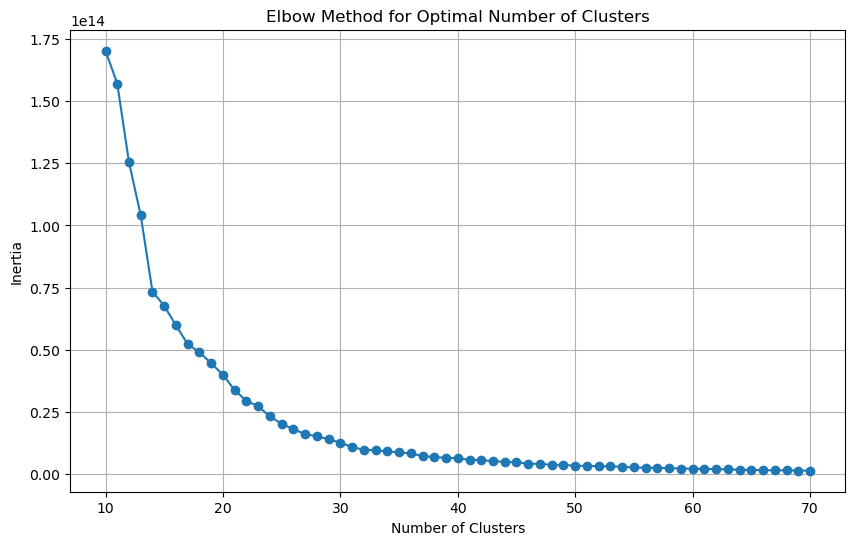

In [39]:
# elbow method to find out the right number of clusters.
# it trying it out for 20, 30 and 50 cluster range, 20 was very inconclusive, 30 was better 
# looking at 50 leads me to think that 25 clusters might be a good number 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



# Compute K-Means for each number of clusters
inertia = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(user_vectors)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

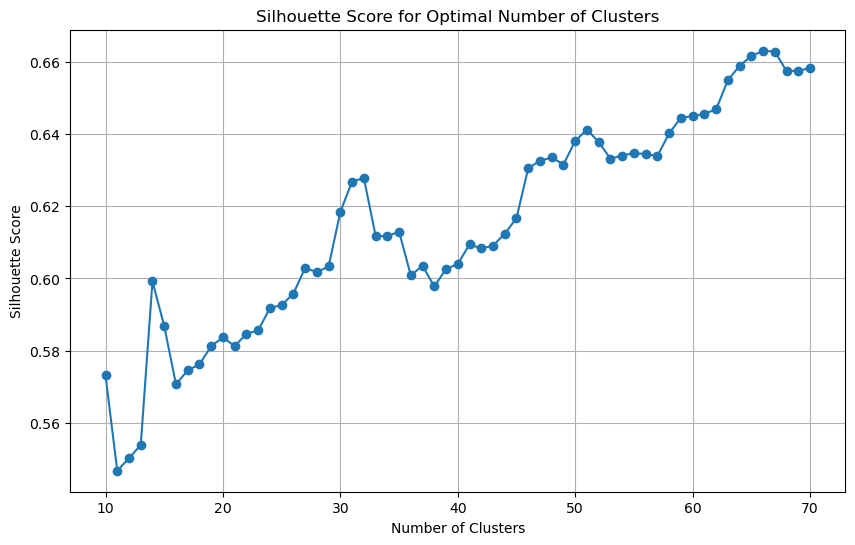

In [40]:
# silhouette score as alternative method to look at potential number of clusters
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(user_vectors)
    silhouette_avg = silhouette_score(user_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
# running several versions of elbow and silhouette with different cluster ranges (up to 70 clusters)
# leads me to decide to go forward with 25 clusters, as it seems to be a reasonable compromise of good*ish
# scores and a manageable number of clusters

In [41]:
#  optimal number of clusters determined is 25, based on the elbow and silhouette score
# calculating several versions of the clusters with up to 75 shows, that no useful clusters can be found
optimal_n_clusters = 35

# Fit K-Means model with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
user_vectors['cluster'] = kmeans.fit_predict(user_vectors)

In [42]:
# Get cluster profiles
cluster_profiles = user_vectors.groupby('cluster').mean()
print(cluster_profiles)

           num_pages  ratings_count   biography   children    comics  \
cluster                                                                
0        1365.037086   3.477833e+05    0.828901   0.245124  0.233599   
1        2012.484171   1.646592e+06    1.118250   0.127095  0.058659   
2        1723.632432   2.707530e+06    0.066667   0.090090  0.000000   
3        2008.033333   4.511307e+06    0.000000   3.966667  0.000000   
4        1931.838679   7.715246e+05    0.986635   0.514702  0.271051   
5        1895.793663   1.354209e+06    1.148456   0.154952  0.063365   
6        1434.844813   2.025302e+06    1.211735   0.102891  0.020833   
7        1451.495690   3.741897e+06    0.056034   0.103448  0.000000   
8        2437.317068   9.475791e+05    1.699937   1.289818  0.829531   
9        2515.000000   5.644565e+06    0.000000   5.000000  0.000000   
10       1142.564426   6.107456e+05    0.730392   0.481092  0.177521   
11        749.645579   2.042735e+05    0.236789   0.037348  0.11

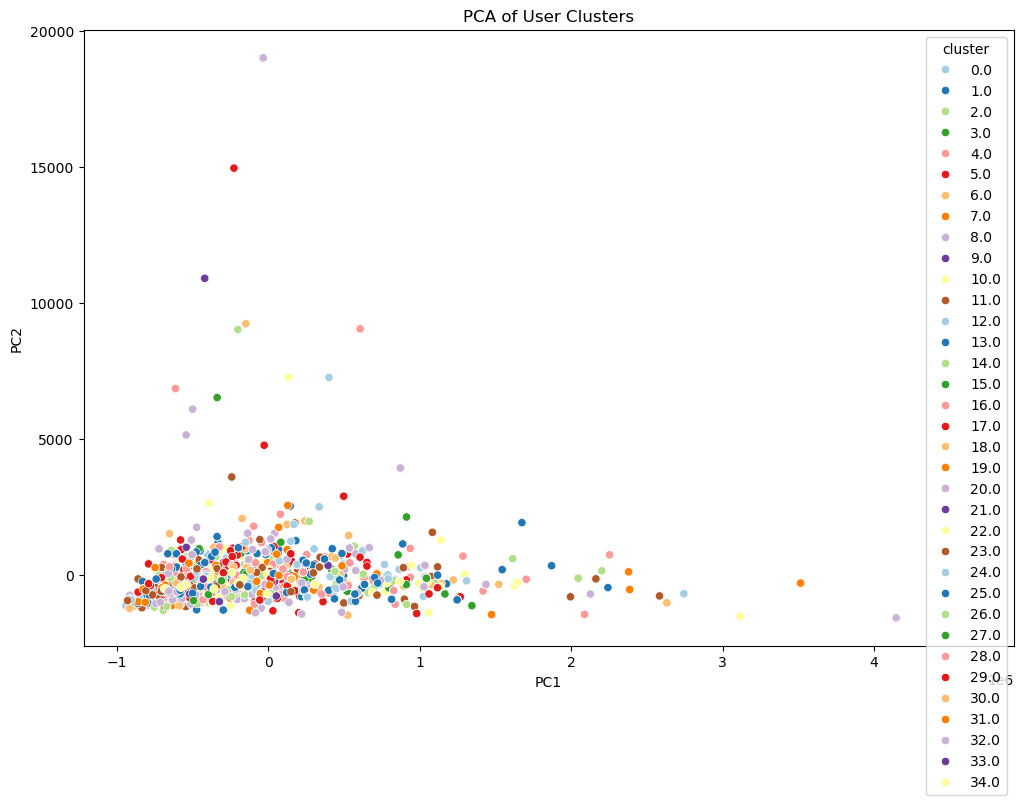

In [43]:
#initially it was viridis color palette, but that was very monotonic, changed it to Paired, still not very helpful

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = user_vectors['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Paired', legend='full')
plt.title('PCA of User Clusters')
plt.show()

In [44]:
# trying out 3d visualization, see if that helps, tried out with 25 clusters, very unsatisfying, trying with 75 clusters, not really helping either
# prepare data for it

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = user_vectors['cluster']

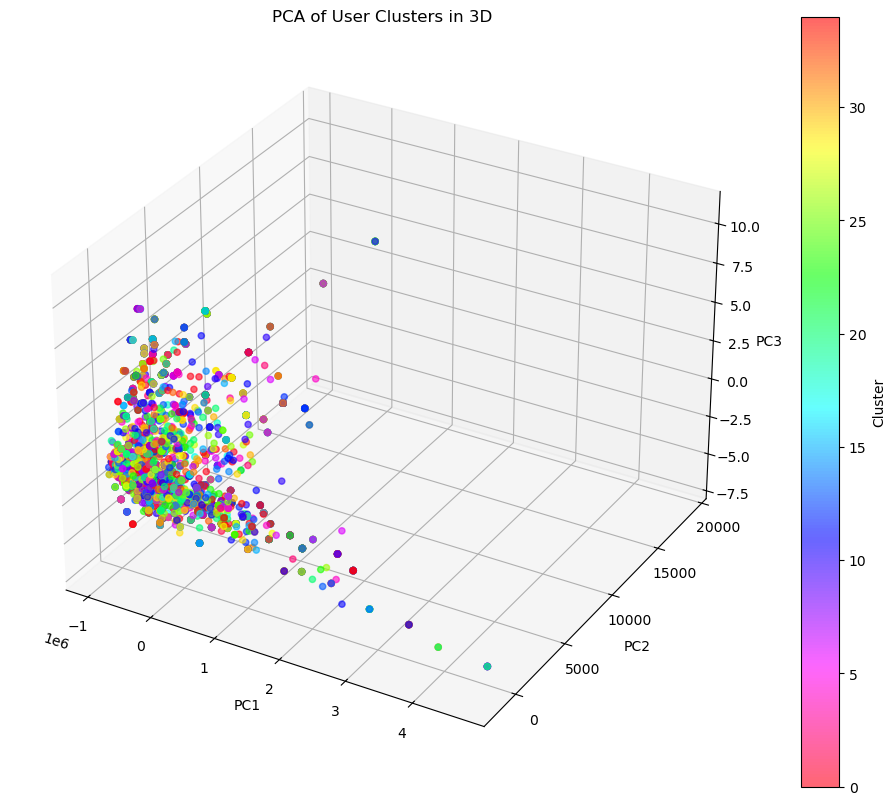

In [45]:
#create 3D scatter plot, starting with Viridis again

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['cluster'], cmap='hsv_r', alpha=0.6)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of User Clusters in 3D')

plt.show()

# Overview der vorhandenen Daten im gemergeten Datensatz ´merged_df´

In [46]:
print (merged_df.columns)

Index(['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating', 'book_id_y', 'title_y',
       'image_url', 'url', 'num_pages', 'ratings_count', 'description', 'name',
       ' biography', ' children', ' comics', ' crime', ' fantasy', ' fiction',
       ' graphic', ' historical fiction', ' history', ' mystery',
       ' nonfiction', ' paranormal', ' poetry', ' romance', ' thriller',
       ' youngadult', 'children', 'comics', 'fantasy', 'fiction', 'mystery',
       'nonfiction', 'poetry', 'romance', 'youngadult'],
      dtype='object')


In [48]:
# inspired by Leas approach to analyze the initial dataset

print(f"Number of observations: {len(merged_df)}")
print(f"Number of unique book ids: {len(merged_df["book_id_x"].unique())}")
print(f"Number of unique user ids: {len(merged_df["user_id_mapping"].unique())}")

#print(f"Average actual rating: {merged_df["Actual Rating"].mean()}")
#print(f"Average predicted rating: {merged_df["Predicted Rating"].mean()}")

#limiting the output to 2 decimal digits for average rating
print(f"Average actual rating: {merged_df['Actual Rating'].mean():.2f}")
print(f"Average predicted rating: {merged_df['Predicted Rating'].mean():.2f}")

Number of observations: 19824
Number of unique book ids: 95
Number of unique user ids: 17103
Average actual rating: 3.87
Average predicted rating: 3.86


In [49]:
#more analyis
# max numnber of ratings per user and others 
# groupby user id
merged_df_userids=merged_df[["user_id_mapping","book_id_x"]].groupby(by="user_id_mapping").count()
merged_df_userids=merged_df_userids.reset_index()
merged_df_userids=merged_df_userids.rename(columns={"book_id_x":"book_count"})

In [51]:
print(f"(repeat) Number of users: {len(merged_df_userids)}")
print(f"Max number of books revied per user: {merged_df_userids.book_count.max()}")
print(f"Min number of books revied per user: {merged_df_userids.book_count.min()}")
print(f"Number of users with 1 review: {len(merged_df_userids.query('book_count == 1'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count == 1'))/len(merged_df_userids),2)*100}%") 
print(f"Number of users with 2 review: {len(merged_df_userids.query('book_count == 2'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count == 2'))/len(merged_df_userids),2)*100}%")
print(f"Number of users with less than 3 reviews: {len(merged_df_userids.query('book_count < 3'))}")
print(f"... in %: {round(len(merged_df_userids.query('book_count < 3'))/len(merged_df_userids),2)*100}%")
print(f"Number of users with more than 1 review: {len(merged_df_userids.query('book_count >1'))}")
#print(f"... in %: {round(len(merged_df_userids.query('book_count >1'))/len(merged_df_userids),2)*100}%") #does not limit it to 1 or 2 digits after the comma
print(f"... in %: {len(merged_df_userids.query('book_count > 1')) / len(merged_df_userids) * 100:.2f}%")

(repeat) Number of users: 17103
Max number of books revied per user: 5
Min number of books revied per user: 1
Number of users with 1 review: 14668
... in %: 86.0%
Number of users with 2 review: 2181
... in %: 13.0%
Number of users with less than 3 reviews: 16849
... in %: 99.0%
Number of users with more than 1 review: 2435
... in %: 14.24%


In [52]:
# group by the user IDs and count the entries per userid
id_counts = merged_df.groupby('user_id_mapping').size()
print(id_counts)

user_id_mapping
2        1
4        1
7        1
21       1
23       1
        ..
84173    1
84179    1
84212    1
84260    1
84282    1
Length: 17103, dtype: int64


In [53]:
# filter for user-ids with 2 or more entries

ids_with_multiple_entries = id_counts[id_counts >= 2].index

# Filter the original DataFrame to only include these IDs
df_filtered = merged_df[merged_df['user_id_mapping'].isin(ids_with_multiple_entries)]
print(ids_with_multiple_entries.shape)
print(df_filtered.shape)

(2435,)
(5156, 39)


In [54]:
#more analyis
# max numnber of ratings per user and others 
# groupby user id

df_filtered_userids=df_filtered[["user_id_mapping","book_id_x"]].groupby(by="user_id_mapping").count()
df_filtered_userids=df_filtered_userids.reset_index()
df_filtered_userids=df_filtered_userids.rename(columns={"book_id_x":"book_count"})

In [55]:
#verifiying that now we have a dataframe where every user has reviewed at least 2 books
print(f"(repeat) Number of users: {len(df_filtered_userids)}")
print(f"Max number of books revied per user: {df_filtered_userids.book_count.max()}")
print(f"Min number of books revied per user: {df_filtered_userids.book_count.min()}")

(repeat) Number of users: 2435
Max number of books revied per user: 5
Min number of books revied per user: 2


In [56]:
#find out a bit of information about the merged and grouped dataset
#we have a dataframe with 5156 lines with entries of 2435 users that have at least 2 ratings, with that we can try to do some predictions
print(f"Number of users with more than 1 review: {len(df_filtered_userids.query('book_count >1'))}")
print(df_filtered_userids.columns)
print(df_filtered_userids.shape)
print(df_filtered.shape)

Number of users with more than 1 review: 2435
Index(['user_id_mapping', 'book_count'], dtype='object')
(2435, 2)
(5156, 39)


In [57]:
print(df_filtered.columns)

Index(['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating', 'book_id_y', 'title_y',
       'image_url', 'url', 'num_pages', 'ratings_count', 'description', 'name',
       ' biography', ' children', ' comics', ' crime', ' fantasy', ' fiction',
       ' graphic', ' historical fiction', ' history', ' mystery',
       ' nonfiction', ' paranormal', ' poetry', ' romance', ' thriller',
       ' youngadult', 'children', 'comics', 'fantasy', 'fiction', 'mystery',
       'nonfiction', 'poetry', 'romance', 'youngadult'],
      dtype='object')


In [58]:
#remove columns that I believe are not needed going forward, e.g with double entry and text only, that cannot be used in the algorithm
df_prediction = df_filtered.drop(['Predicted Rating', 'book_id_y', 'title_y', 'description', 'image_url', 'url', 'name'],axis=1 )

In [59]:
#verify that my code did want I wanted it to do
print(df_prediction.columns)

Index(['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping',
       'Actual Rating', 'num_pages', 'ratings_count', ' biography',
       ' children', ' comics', ' crime', ' fantasy', ' fiction', ' graphic',
       ' historical fiction', ' history', ' mystery', ' nonfiction',
       ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult',
       'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction',
       'poetry', 'romance', 'youngadult'],
      dtype='object')


In [62]:
print(df_prediction.head())
print(df_prediction.shape)

                       title_x  book_id_x  user_id_mapping  book_id_mapping  \
1   We Should All Be Feminists   22738563            45548              873   
4   We Should All Be Feminists   22738563            41888              873   
10  We Should All Be Feminists   22738563            19426              873   
13  We Should All Be Feminists   22738563            46744              873   
14  We Should All Be Feminists   22738563            26977              873   

    Actual Rating  num_pages  ratings_count   biography   children   comics  \
1               4       1007         151473           0          0        0   
4               5       1007         151473           0          0        0   
10              5       1007         151473           0          0        0   
13              5       1007         151473           0          0        0   
14              4       1007         151473           0          0        0   

    ...   youngadult  children  comics  fantasy  f

Based on what we did in Hamburg I wanted to plot the actual rating against the other features to see if there any patterns visible. Here te preparation for the data frame to be able to do this. 

In [61]:
# not sure I need this here
#making the columns to feature to prepare prediction
# starting with all columns in the df are features
X = df_prediction.copy()  # Copy the DataFrame to preserve the original
print(X)

                               title_x  book_id_x  user_id_mapping  \
1           We Should All Be Feminists   22738563            45548   
4           We Should All Be Feminists   22738563            41888   
10          We Should All Be Feminists   22738563            19426   
13          We Should All Be Feminists   22738563            46744   
14          We Should All Be Feminists   22738563            26977   
...                                ...        ...              ...   
19816  The Wonderful Wizard of Oz Oz 1     236093             6263   
19817  The Wonderful Wizard of Oz Oz 1     236093            27954   
19818  The Wonderful Wizard of Oz Oz 1     236093            24286   
19819  The Wonderful Wizard of Oz Oz 1     236093            16631   
19822  The Wonderful Wizard of Oz Oz 1     236093             6029   

       book_id_mapping  Actual Rating  num_pages  ratings_count   biography  \
1                  873              4       1007         151473           0   
4

In [63]:
#don't think I need that here
# #df_prediction.feature_names

In [64]:
#try to visualize the data a bit 
sns.set(font_scale=1)
sns.set_style('whitegrid')    

In [65]:
# Access the feature names
feature_names = df_prediction.columns.tolist()
print("Feature names:", feature_names)

Feature names: ['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping', 'Actual Rating', 'num_pages', 'ratings_count', ' biography', ' children', ' comics', ' crime', ' fantasy', ' fiction', ' graphic', ' historical fiction', ' history', ' mystery', ' nonfiction', ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult', 'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction', 'poetry', 'romance', 'youngadult']


In [66]:
# Adding the feature_names as an attribute to the DataFrame
df_prediction.feature_names = df_prediction.columns.tolist()

# Access the custom attribute
print("Feature names attribute:", df_prediction.feature_names)

Feature names attribute: ['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping', 'Actual Rating', 'num_pages', 'ratings_count', ' biography', ' children', ' comics', ' crime', ' fantasy', ' fiction', ' graphic', ' historical fiction', ' history', ' mystery', ' nonfiction', ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult', 'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction', 'poetry', 'romance', 'youngadult']


/var/folders/hd/1qz63p5x7p3fcyckl8033hm40000gn/T/ipykernel_3451/354344605.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_prediction.feature_names = df_prediction.columns.tolist()


In [67]:
print(df_prediction)

                               title_x  book_id_x  user_id_mapping  \
1           We Should All Be Feminists   22738563            45548   
4           We Should All Be Feminists   22738563            41888   
10          We Should All Be Feminists   22738563            19426   
13          We Should All Be Feminists   22738563            46744   
14          We Should All Be Feminists   22738563            26977   
...                                ...        ...              ...   
19816  The Wonderful Wizard of Oz Oz 1     236093             6263   
19817  The Wonderful Wizard of Oz Oz 1     236093            27954   
19818  The Wonderful Wizard of Oz Oz 1     236093            24286   
19819  The Wonderful Wizard of Oz Oz 1     236093            16631   
19822  The Wonderful Wizard of Oz Oz 1     236093             6029   

       book_id_mapping  Actual Rating  num_pages  ratings_count   biography  \
1                  873              4       1007         151473           0   
4

/var/folders/hd/1qz63p5x7p3fcyckl8033hm40000gn/T/ipykernel_3451/434110467.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4.5))  # 8"-by-4.5" Figure


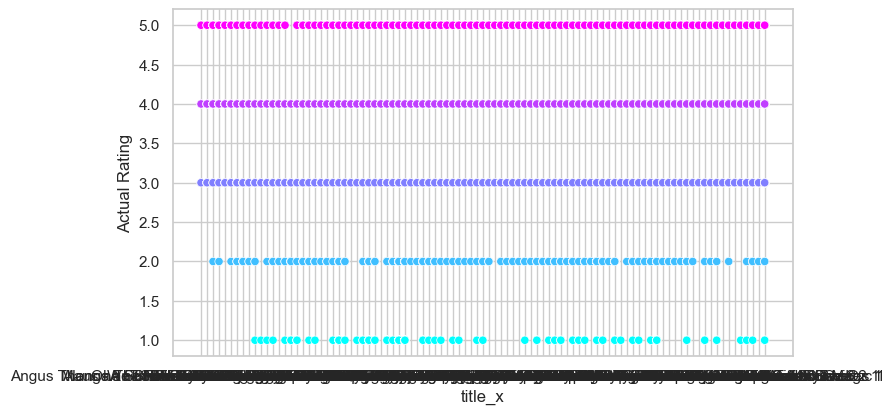

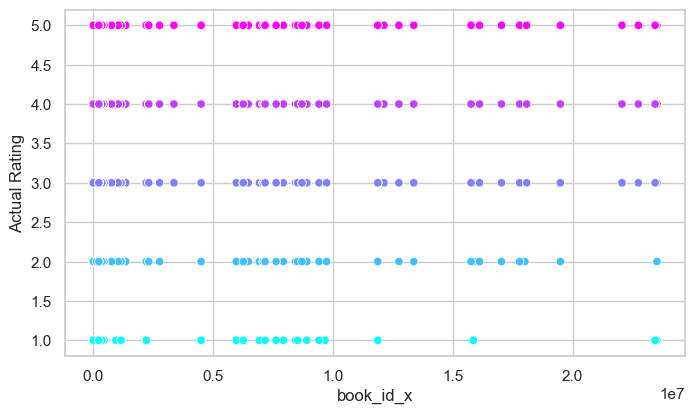

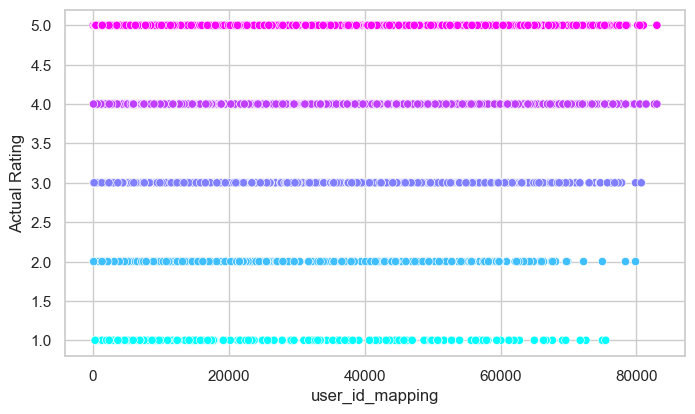

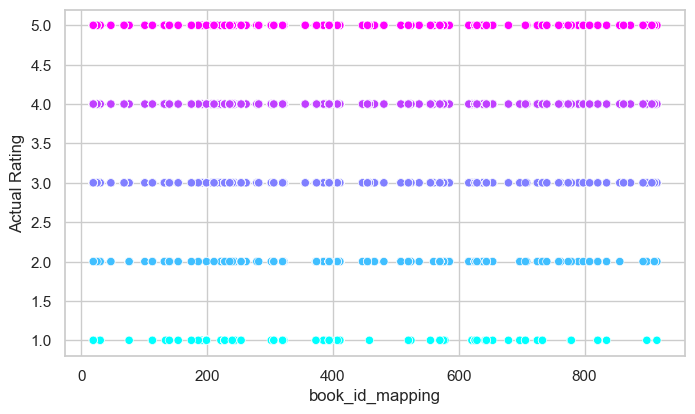

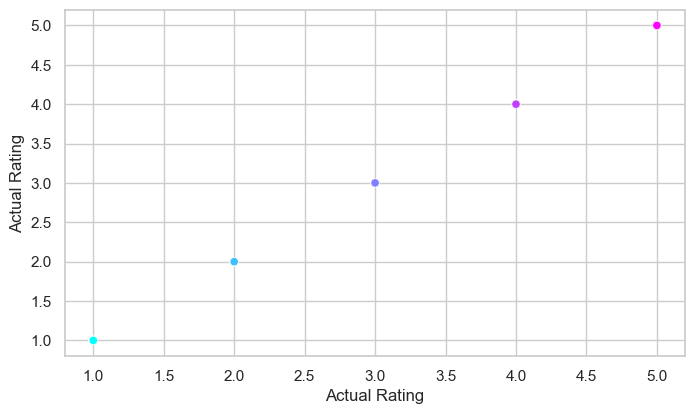

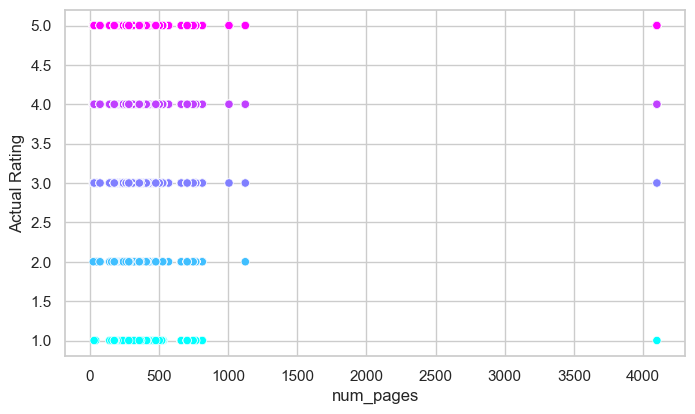

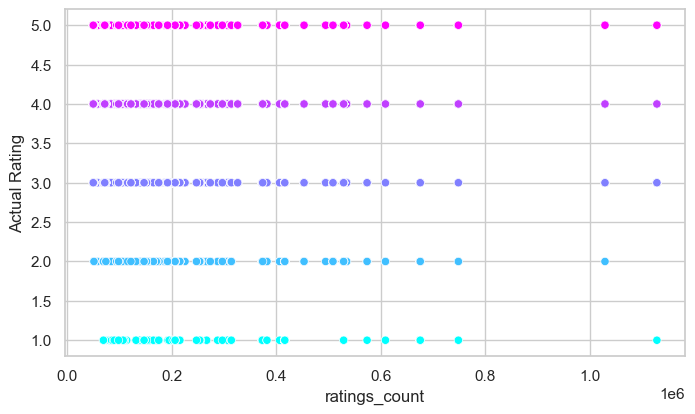

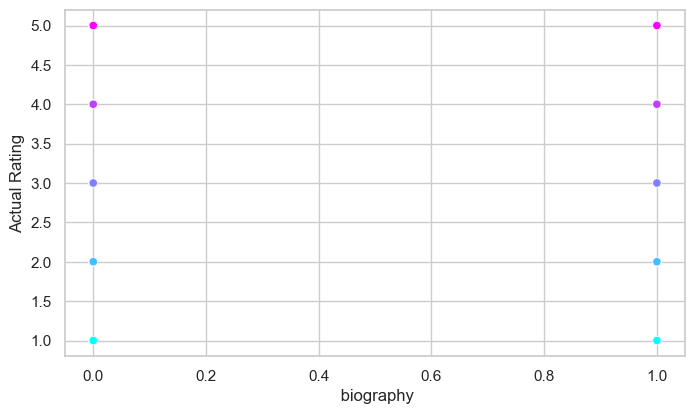

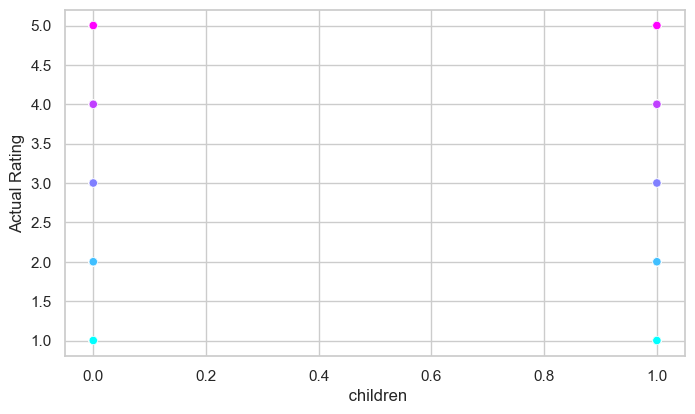

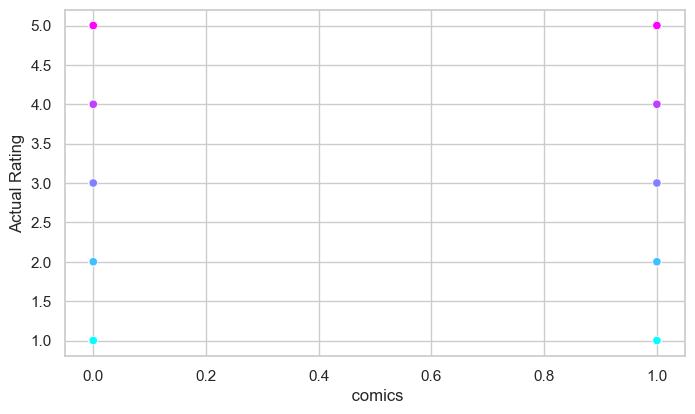

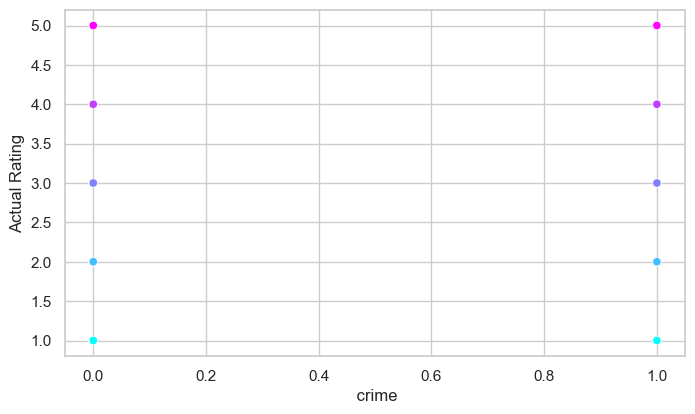

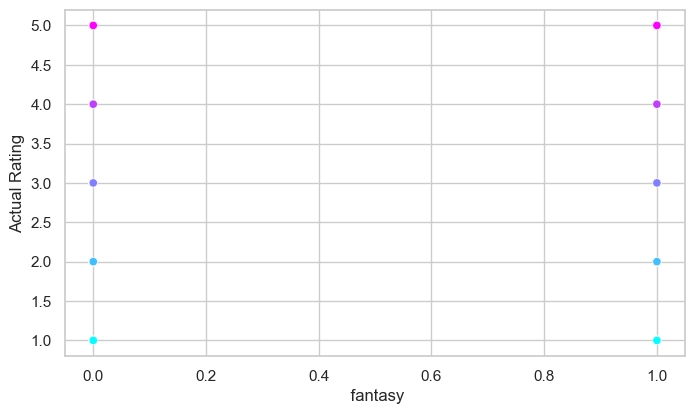

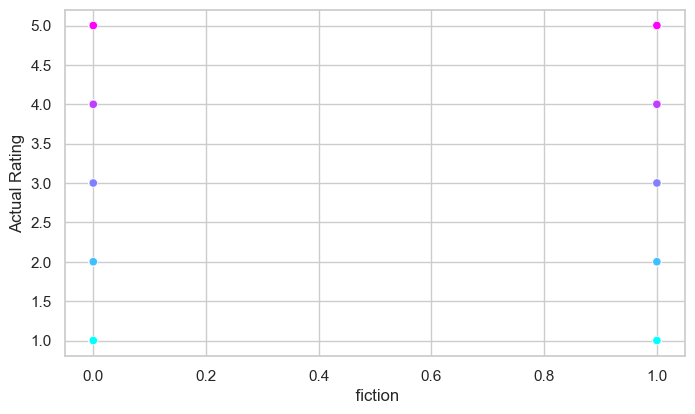

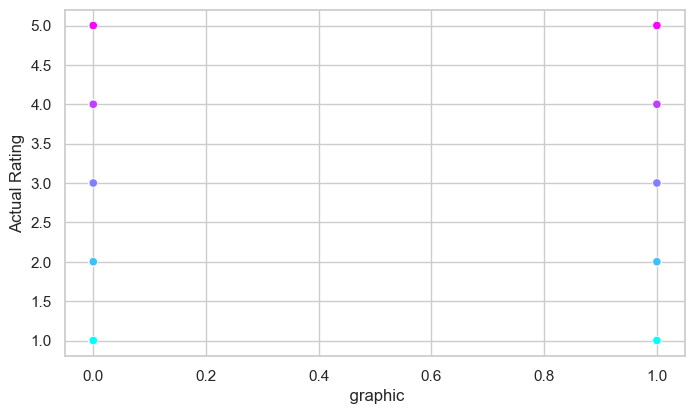

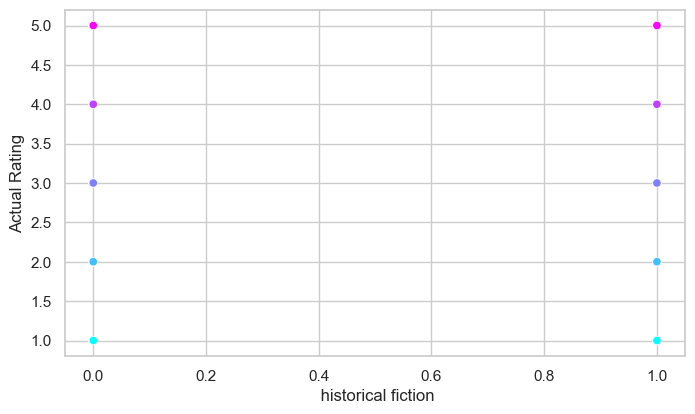

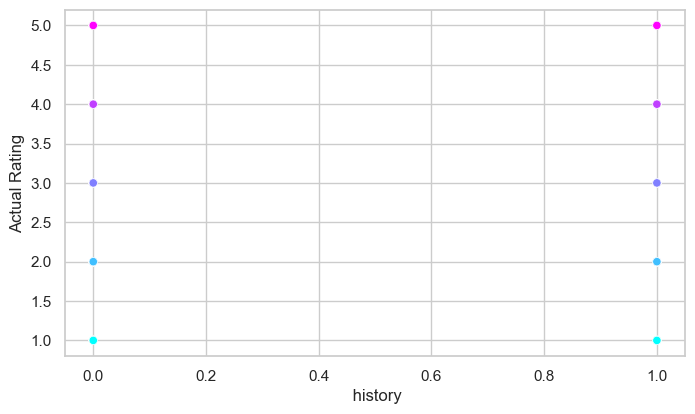

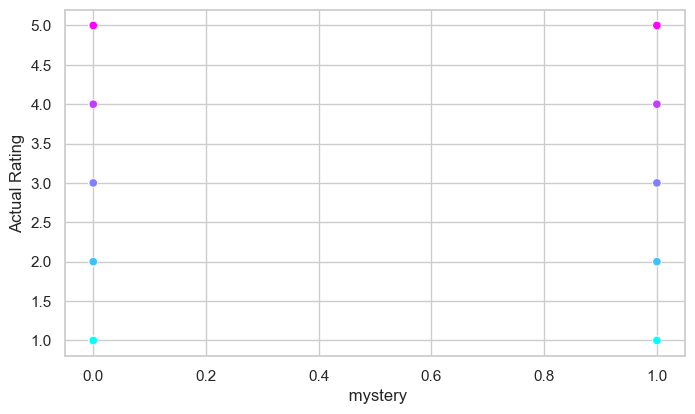

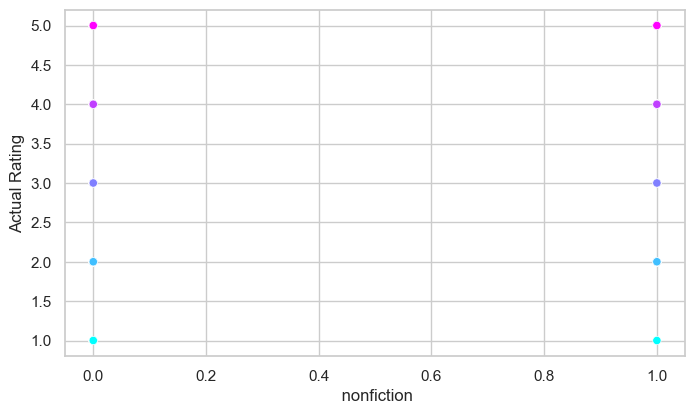

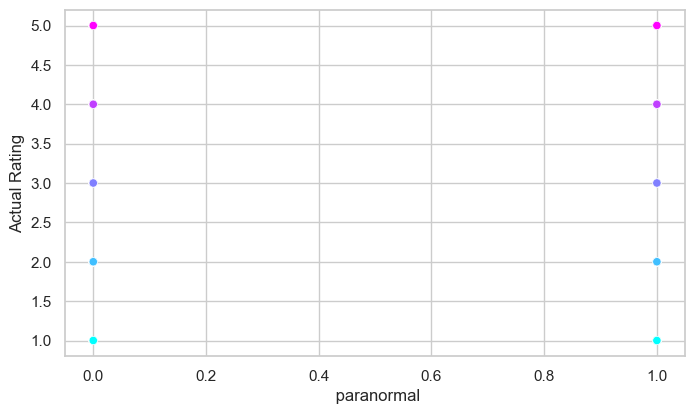

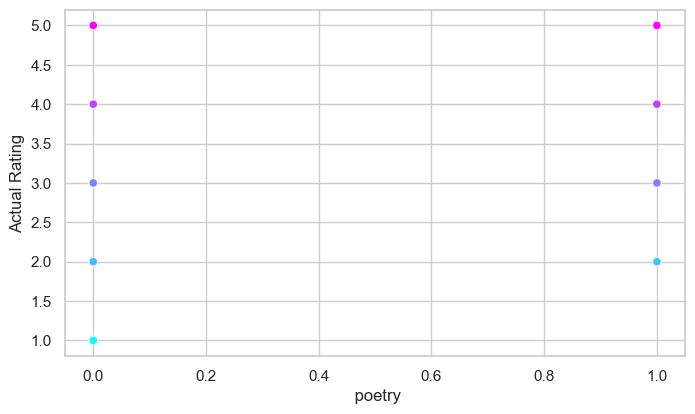

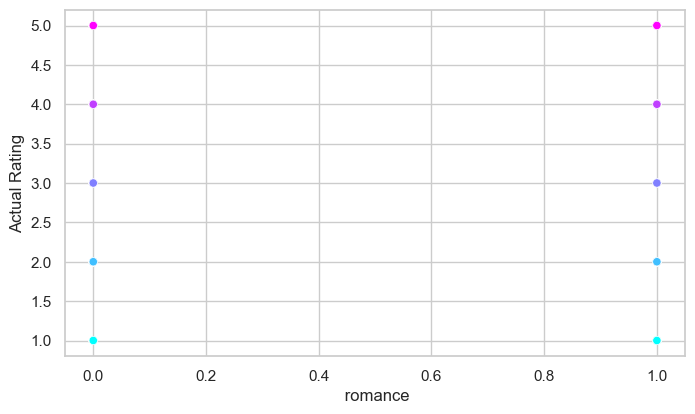

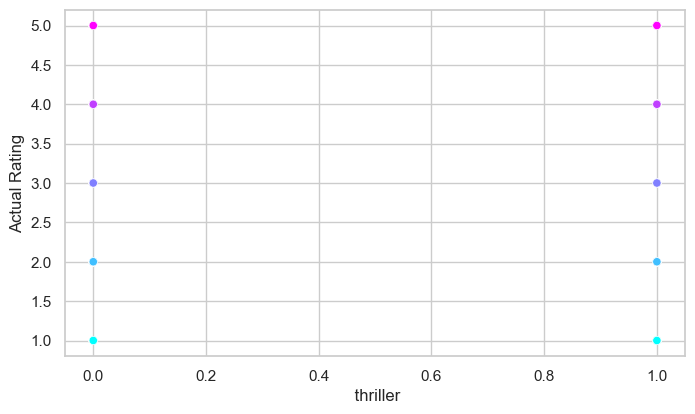

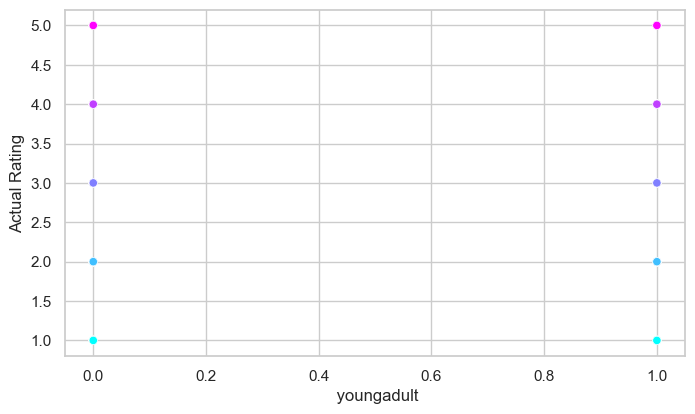

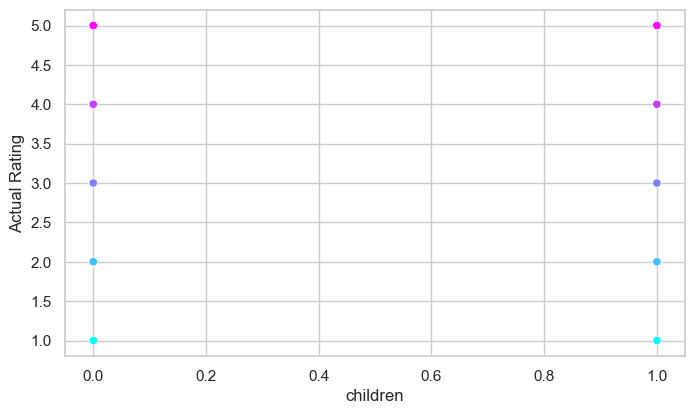

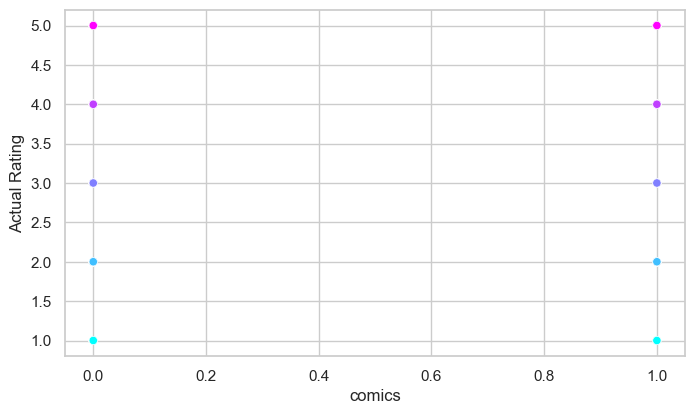

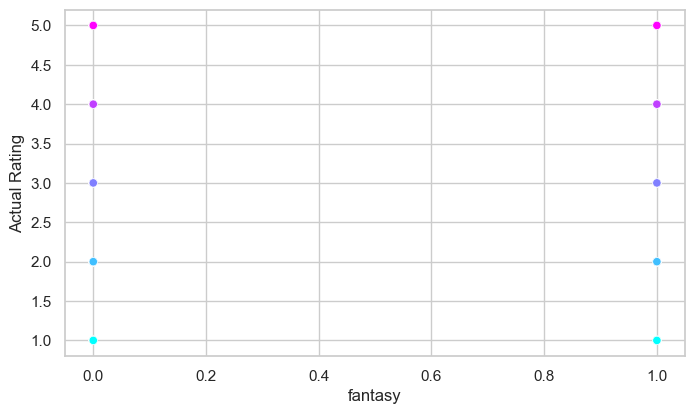

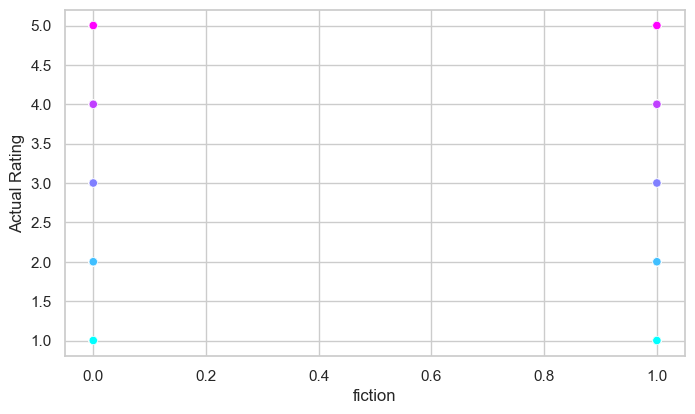

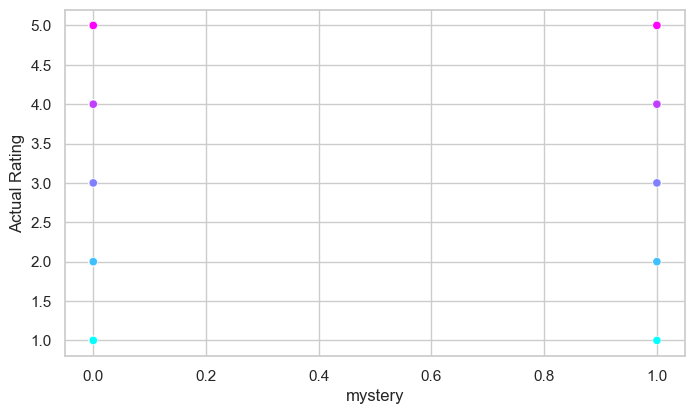

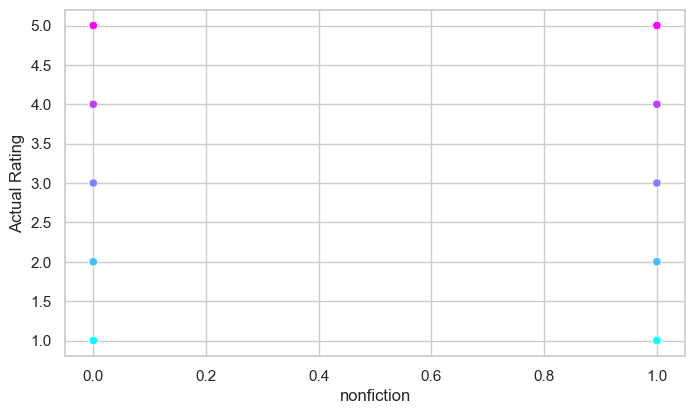

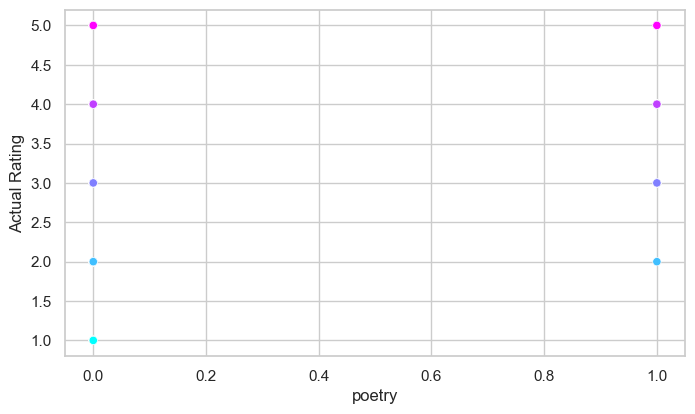

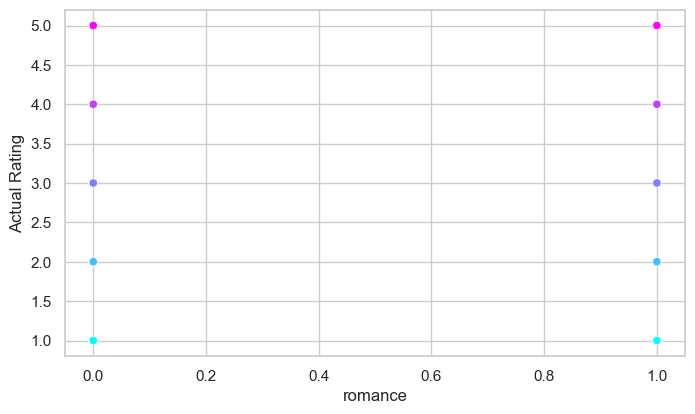

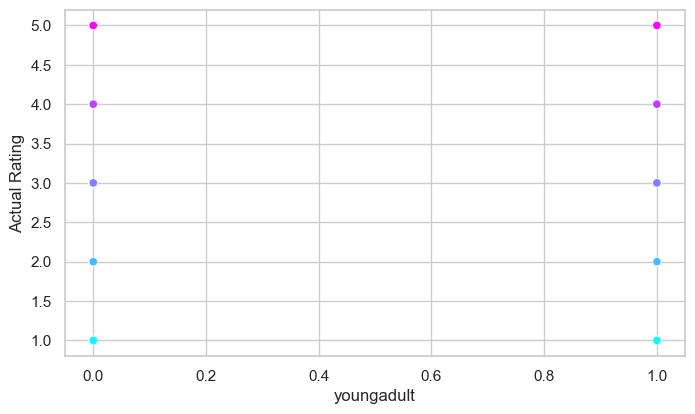

In [68]:
# aus der Vorlesung: versuch die ergebnisse gegen die einzelnen features zu plotten
# wie sie sie sehen, sehen sie nix, daraus kann man erst mal nix ablesen
#next steps - wieder einen vektor pro nutzer, dann nochmal versuchen

for feature in df_prediction.feature_names:
    plt.figure(figsize=(8, 4.5))  # 8"-by-4.5" Figure
    sns.scatterplot(data=df_prediction, x=feature, 
                    y='Actual Rating', hue='Actual Rating', 
                    palette='cool', legend=False)

Create one vector per user
for whatever reason, what I did before does not work now anymore

new try
df_filtered is the dataframe to start with

In [69]:
print(df_filtered.shape)
print(df_filtered.columns)

(5156, 39)
Index(['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating', 'book_id_y', 'title_y',
       'image_url', 'url', 'num_pages', 'ratings_count', 'description', 'name',
       ' biography', ' children', ' comics', ' crime', ' fantasy', ' fiction',
       ' graphic', ' historical fiction', ' history', ' mystery',
       ' nonfiction', ' paranormal', ' poetry', ' romance', ' thriller',
       ' youngadult', 'children', 'comics', 'fantasy', 'fiction', 'mystery',
       'nonfiction', 'poetry', 'romance', 'youngadult'],
      dtype='object')


now try to boil it down to 1 vector per user

In [70]:
df_for_prediction = df_filtered.drop(['Predicted Rating', 'book_id_y', 'title_y', 'description', 'image_url', 'url', 'name'],axis=1 )

In [71]:
print(df_for_prediction.shape)
print(df_for_prediction.columns)

(5156, 32)
Index(['title_x', 'book_id_x', 'user_id_mapping', 'book_id_mapping',
       'Actual Rating', 'num_pages', 'ratings_count', ' biography',
       ' children', ' comics', ' crime', ' fantasy', ' fiction', ' graphic',
       ' historical fiction', ' history', ' mystery', ' nonfiction',
       ' paranormal', ' poetry', ' romance', ' thriller', ' youngadult',
       'children', 'comics', 'fantasy', 'fiction', 'mystery', 'nonfiction',
       'poetry', 'romance', 'youngadult'],
      dtype='object')


In [72]:
user_metadata_df = df_filtered.copy()

In [73]:
print(user_metadata_df.shape)

(5156, 39)


In [74]:
# make sure all columns are numeric columns
df_for_prediction = df_for_prediction.apply(pd.to_numeric, errors='coerce')

In [75]:
print(df_for_prediction.shape)

(5156, 32)


Creating user vectors based on different methods
- mean
- median
- sum 

In [76]:
#create one vector per user, use different methods to create them so that we have different inputs for predictions
#user vectors using mean
user_vectors_mean = df_for_prediction.groupby('user_id_mapping').mean()
print(user_vectors_mean)

                 title_x   book_id_x  book_id_mapping  Actual Rating  \
user_id_mapping                                                        
55                   NaN    315189.0            552.0            3.5   
91                   NaN    195883.5            453.0            3.5   
103                  NaN    596363.0            259.5            4.5   
114                  NaN   3554811.5            202.0            2.5   
117                  NaN      9296.0            403.0            2.5   
...                  ...         ...              ...            ...   
80709                NaN      7848.0            610.0            3.0   
80998                NaN   5449736.5            205.0            5.0   
81410                NaN  14449805.5            203.5            4.0   
82619                NaN   1114202.0            566.5            4.0   
83005                NaN   4240452.0            395.0            4.5   

                 num_pages  ratings_count   biography   childre

In [77]:
user_vectors_sum = df_for_prediction.groupby('user_id_mapping').sum()
print(user_vectors_sum)

                 title_x  book_id_x  book_id_mapping  Actual Rating  \
user_id_mapping                                                       
55                   0.0     630378             1104              7   
91                   0.0     391767              906              7   
103                  0.0    1192726              519              9   
114                  0.0    7109623              404              5   
117                  0.0      18592              806              5   
...                  ...        ...              ...            ...   
80709                0.0      15696             1220              6   
80998                0.0   10899473              410             10   
81410                0.0   28899611              407              8   
82619                0.0    2228404             1133              8   
83005                0.0    8480904              790              9   

                 num_pages  ratings_count   biography   children   comics  \

In [78]:
# user vectors using median

user_vectors_median = df_for_prediction.groupby('user_id_mapping').median()
print(user_vectors_median)

                 title_x   book_id_x  book_id_mapping  Actual Rating  \
user_id_mapping                                                        
55                   NaN    315189.0            552.0            3.5   
91                   NaN    195883.5            453.0            3.5   
103                  NaN    596363.0            259.5            4.5   
114                  NaN   3554811.5            202.0            2.5   
117                  NaN      9296.0            403.0            2.5   
...                  ...         ...              ...            ...   
80709                NaN      7848.0            610.0            3.0   
80998                NaN   5449736.5            205.0            5.0   
81410                NaN  14449805.5            203.5            4.0   
82619                NaN   1114202.0            566.5            4.0   
83005                NaN   4240452.0            395.0            4.5   

                 num_pages  ratings_count   biography   childre

# Start the prediction

Get started with user_vector_mean
linear regression, no normalization

In [80]:
#the code I wanted to run did not go through due to missing values... finding the missing values now and cleaning up
#check the missing values per column - title_x has missing values - therefore drop that column
missing_values = user_vectors_mean.isnull().sum()
print(missing_values)

title_x                2435
book_id_x                 0
book_id_mapping           0
Actual Rating             0
num_pages                 0
ratings_count             0
 biography                0
 children                 0
 comics                   0
 crime                    0
 fantasy                  0
 fiction                  0
 graphic                  0
 historical fiction       0
 history                  0
 mystery                  0
 nonfiction               0
 paranormal               0
 poetry                   0
 romance                  0
 thriller                 0
 youngadult               0
children                  0
comics                    0
fantasy                   0
fiction                   0
mystery                   0
nonfiction                0
poetry                    0
romance                   0
youngadult                0
dtype: int64


In [82]:
#column title_x has missing values, so I drop it
user_vectors_mean = user_vectors_mean.drop(columns=['title_x'])


KeyError: "['title_x'] not found in axis"

In [83]:
print(user_vectors_mean.shape)

(2435, 30)


now, having done the other steps first, it should be possible to run the following code

outcome: not good

Mean Squared Error: 0.6478485122777936

R-squared: 0.0412460789151855

In [94]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is called user_vector_median

# Separate features (X) and target (y)
# Assuming "Actual Rating" is the column you're predicting and the rest are features
X = user_vectors_mean.drop(columns=['Actual Rating'])
y = user_vectors_mean['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# If you want to inspect the coefficients of the regression model
coefficients = model.coef_
print("Model coefficients:", coefficients)

Mean Squared Error: 0.6478485122777936
R-squared: 0.0412460789151855
Model coefficients: [ 2.63493992e-08 -3.79030052e-05 -1.16683418e-05 -3.01571162e-07
  1.80817528e-02  2.11929720e-02 -2.51831225e-01 -1.52212777e-02
 -5.62134864e-02  7.06524745e-02 -1.47290233e-01  1.80817528e-02
  1.80817528e-02  1.09350865e-01 -4.10029084e-01 -1.76467282e-01
  2.68566204e-01 -5.70973836e-02 -1.52212777e-02 -9.60572826e-02
  3.35955356e-01  1.04540991e-01 -1.20253796e-01 -2.14245208e-01
 -1.24572143e-01 -6.60478566e-02  7.17645724e-01 -3.68187597e-01
 -2.64835472e-01]


Doing it all now for the next user vectore
user_vectors_sum

Result is better than with mean, but not yet satisfying

Mean Squared Error: 2.8747540695971443

R-squared: 0.37543279109204053


In [86]:

#check the missing values per column - title_x has missing values - therefore drop that column
missing_values = user_vectors_sum.isnull().sum()
print(missing_values)

title_x                0
book_id_x              0
book_id_mapping        0
Actual Rating          0
num_pages              0
ratings_count          0
 biography             0
 children              0
 comics                0
 crime                 0
 fantasy               0
 fiction               0
 graphic               0
 historical fiction    0
 history               0
 mystery               0
 nonfiction            0
 paranormal            0
 poetry                0
 romance               0
 thriller              0
 youngadult            0
children               0
comics                 0
fantasy                0
fiction                0
mystery                0
nonfiction             0
poetry                 0
romance                0
youngadult             0
dtype: int64


In [109]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is called user_vector_median

# Separate features (X) and target (y)
# Assuming "Actual Rating" is the column you're predicting and the rest are features
X = user_vectors_sum.drop(columns=['Actual Rating'])
y = user_vectors_sum['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# If you want to inspect the coefficients of the regression model
coefficients = model.coef_
print("Model coefficients:", coefficients)

Mean Squared Error: 2.8747540695971443
R-squared: 0.37543279109204053
Model coefficients: [ 3.21184498e-09  2.70500859e-08 -2.52468862e-05 -4.34661844e-06
 -2.91400615e-07  5.96690023e-03  1.08397060e-02 -1.68443603e+00
  8.12794928e-01 -1.45988871e+00  3.84531872e-03  1.24357537e+00
  5.96690023e-03  5.96690023e-03 -1.55079642e+00 -4.17526053e-01
  1.21615461e+00  2.77372832e-01 -8.53441307e-02  8.12794928e-01
 -7.08214789e-02  4.48051284e+00  2.92801140e+00  2.67604332e+00
  3.91405963e+00  2.36359135e+00  4.16789789e+00  4.97759466e+00
  3.80439112e+00  3.94642675e+00]


Doing it all now for the next user vector
user_vectors_median

Result is better than with mean, but not yet satisfying either

Mean Squared Error: 0.6683919894292838
R-squared: 0.03712562568513289


In [90]:
#check the missing values per column - title_x has missing values - therefore drop that column
missing_values = user_vectors_median.isnull().sum()
print(missing_values)

book_id_x              0
book_id_mapping        0
Actual Rating          0
num_pages              0
ratings_count          0
 biography             0
 children              0
 comics                0
 crime                 0
 fantasy               0
 fiction               0
 graphic               0
 historical fiction    0
 history               0
 mystery               0
 nonfiction            0
 paranormal            0
 poetry                0
 romance               0
 thriller              0
 youngadult            0
children               0
comics                 0
fantasy                0
fiction                0
mystery                0
nonfiction             0
poetry                 0
romance                0
youngadult             0
dtype: int64


In [89]:
#column title_x has missing values, so I drop it
user_vectors_median = user_vectors_median.drop(columns=['title_x'])

In [91]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming your dataframe is called user_vector_median

# Separate features (X) and target (y)
# Assuming "Actual Rating" is the column you're predicting and the rest are features
X = user_vectors_median.drop(columns=['Actual Rating'])
y = user_vectors_median['Actual Rating']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# If you want to inspect the coefficients of the regression model
coefficients = model.coef_
print("Model coefficients:", coefficients)

Mean Squared Error: 0.6683919894292838
R-squared: 0.03712562568513289
Model coefficients: [ 2.47097435e-08  1.82365262e-05 -3.51546218e-05 -1.76529194e-07
 -4.66776503e-03 -5.56946392e-02 -4.28308384e-01 -1.39932589e-01
 -4.23496501e-03  1.58278271e-01  7.74662877e-02 -4.66776503e-03
 -4.66776503e-03  3.34178252e-01 -3.50976551e-01 -1.47265532e-01
  2.42532636e-01 -1.28019833e-01 -1.39932589e-01 -5.24950461e-02
  3.11040349e-01  3.55062892e-02  7.78576569e-02  3.50146338e-02
  3.62133272e-01  1.32557809e-01  5.84622553e-01 -2.40949634e-01
 -7.62400498e-02]


Best model so far was with user_vectors_sum, I will try to tweak the model based on this. 

1st Iteration of trying to improve: 
normalizing/ standardizing the features

This is where we started:
Mean Squared Error: 2.8747540695971443

R-squared: 0.37543279109204053


This is the result - it did not get better but rather worse
Mean Squared Error: 2.8793309884843996
R-squared: 0.3744384126563185

In [110]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model with scaled data
model.fit(X_train_scaled, y_train)

# Predict on the scaled test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# If you want to inspect the coefficients of the regression model
coefficients = model.coef_
print("Model coefficients:", coefficients)

Mean Squared Error: 2.8793309884843996
R-squared: 0.3744384126563185
Model coefficients: [ 7.73048717e-17  2.43115028e-01 -4.48976847e-02  2.40427138e-02
 -5.69770689e-02  1.81566155e+10 -2.74841339e-02 -3.46669771e+11
 -1.71657472e+13  8.99873195e+11 -1.40879247e-01  4.33665594e+11
  2.50261896e+11 -2.68418512e+11  1.50051332e+13 -1.64454767e-01
 -9.92011827e+11  8.64737462e-02 -8.04706959e-02  1.87918277e+12
 -4.08669849e-02  1.07889578e+00 -2.88358289e+11  9.68384098e+11
  2.18654962e+00  4.29289979e+12  2.04836412e+00  6.92901498e-01
  1.45464701e+00  2.35926915e+00]


Next try - apply ridgre regression model with regularization 

This is where we started:
Mean Squared Error: 2.8747540695971443

R-squared: 0.37543279109204053


This is the result with tunining parameter alpha = 1.0 - it did get minimally better, not really worth the effort
Mean Squared Error: 2.8737646386033306
R-squared: 0.3756477542294959

Try outs with 0.1 < alpha <10 leads to the results that R-squared does not get better than 0.375

In [101]:
from sklearn.linear_model import Ridge

# Create a Ridge Regression model with regularization
ridge_model = Ridge(alpha=10)  # You can tune alpha (regularization strength)

# Fit the model
ridge_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# If you want to inspect the coefficients of the regression model
coefficients = model.coef_
print("Model coefficients:", coefficients)

Mean Squared Error: 2.885716961100434
R-squared: 0.37305100037812045
Model coefficients: [ 3.21184498e-09  2.70500859e-08 -2.52468862e-05 -4.34661844e-06
 -2.91400615e-07  5.96690023e-03  1.08397060e-02 -1.68443603e+00
  8.12794928e-01 -1.45988871e+00  3.84531872e-03  1.24357537e+00
  5.96690023e-03  5.96690023e-03 -1.55079642e+00 -4.17526053e-01
  1.21615461e+00  2.77372832e-01 -8.53441307e-02  8.12794928e-01
 -7.08214789e-02  4.48051284e+00  2.92801140e+00  2.67604332e+00
  3.91405963e+00  2.36359135e+00  4.16789789e+00  4.97759466e+00
  3.80439112e+00  3.94642675e+00]


Now trying it out with Lasso method

This is where we started:
Mean Squared Error: 2.8747540695971443

R-squared: 0.37543279109204053

This is the result with tunining parameter alpha = 1.0 - it did get worse
Mean Squared Error: 3.3486685307714454
R-squared: 0.2724704419272538

Try outs with minimizing alpha lead to a result nearing 0.375 again, so also not worth the effort

In [108]:
from sklearn.linear_model import Lasso

# Create a Lasso Regression model
lasso_model = Lasso(alpha=0.0005)  # Tune alpha

# Fit and predict
lasso_model.fit(X_train_scaled, y_train)
y_pred = lasso_model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# If you want to inspect the coefficients of the regression model
coefficients = model.coef_
print("Model coefficients:", coefficients)

Mean Squared Error: 2.87367643513463
R-squared: 0.37566691725802936
Model coefficients: [ 3.21184498e-09  2.70500859e-08 -2.52468862e-05 -4.34661844e-06
 -2.91400615e-07  5.96690023e-03  1.08397060e-02 -1.68443603e+00
  8.12794928e-01 -1.45988871e+00  3.84531872e-03  1.24357537e+00
  5.96690023e-03  5.96690023e-03 -1.55079642e+00 -4.17526053e-01
  1.21615461e+00  2.77372832e-01 -8.53441307e-02  8.12794928e-01
 -7.08214789e-02  4.48051284e+00  2.92801140e+00  2.67604332e+00
  3.91405963e+00  2.36359135e+00  4.16789789e+00  4.97759466e+00
  3.80439112e+00  3.94642675e+00]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.204e+02, tolerance: 8.861e-01
  model = cd_fast.enet_coordinate_descent(


Trying out cross validation, to see if this improves it
Before starting, I executed the code again for user_vectors_sum and then for the scaler, to ensure I start with the right data into the cross validation

This is where we started:
Mean Squared Error: 2.8747540695971443
R-squared: 0.37543279109204053

This is the result, with a 5fold cross validation
Cross-validated R-squared scores: [0.4414783  0.47124763 0.43147318 0.44211813 0.30602363]
Mean R-squared: 0.4184681729038432

This is the result, with a 10fold cross validation
Cross-validated R-squared scores: [0.31469016 0.45364744 0.47981629 0.43729431 0.4728822  0.39495923
 0.36394261 0.49824312 0.32484085 0.41584173]
Mean R-squared: 0.41561579448026603

Increasing the folds does not improve R-squared

Score with 3-fold cross validation
Cross-validated R-squared scores: [0.46044342 0.37694054 0.422745  ]
Mean R-squared: 0.42004298618043784 - this is so far the best result, but unfortunately not yet satisfying




In [118]:
#from sklearn.model_selection import cross_val_score not needed anymore after the first time


# Perform 5-fold cross-validation with R-squared as the scoring metric
cv_r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='r2')

# Output the individual R-squared values for each fold
print(f'Cross-validated R-squared scores: {cv_r2_scores}')

# Output the mean R-squared value across all folds
print(f'Mean R-squared: {cv_r2_scores.mean()}')

Cross-validated R-squared scores: [0.46044342 0.37694054 0.422745  ]
Mean R-squared: 0.42004298618043784


Next approach to tweak the model - Feature selection
let's see if all the features are actually needed - with recursive feature elimination
start with 10 features to select

not helpful at all

Outcome:
Mean Squared Error: 4.21
R-squared: 0.09


In [120]:
from sklearn.feature_selection import RFE

# Use RFE to select the best features
selector = RFE(model, n_features_to_select=10)
selector = selector.fit(X_train_scaled, y_train)

# Transform the datasets to only use selected features
X_train_rfe = selector.transform(X_train_scaled)
X_test_rfe = selector.transform(X_test_scaled)

# Fit the model with selected features
model.fit(X_train_rfe, y_train)

# Predict on the selected test set
y_pred = model.predict(X_test_rfe)

# evaluation for the model after feature selection

rfe_mse = mean_squared_error(y_test, y_pred)
rfe_r2 = r2_score(y_test, y_pred)

print(f'RFE Model - MSE: {rfe_mse:.2f}, R-squared: {rfe_r2:.2f}')

RFE Model - MSE: 4.21, R-squared: 0.09


Using more complex models - Random Forest
with n_estimators=100, random_state=42 the results are not helping

Mean Squared Error: 3.388927720124742
R-squared: 0.26372375650006896

Adjusting the parameters does not change the numbers significantly, so also not helpful


In [128]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=20, random_state=42)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared score

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 3.4868079555540477
R-squared: 0.24245835988897646
